## Dataset

In [4]:
import tiktoken
import torch

with open('input.txt', 'r') as f:
    text = f.read()

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(text)

print("=" * 70)
print("DATASET DIAGNOSTICS")
print("=" * 70)
print(f"Total characters: {len(text):,}")
print(f"Total tokens: {len(tokens):,}")
print(f"Unique tokens in dataset: {len(set(tokens)):,} / 50257 total vocab")
print(f"\n First 300 characters of data:")
print("-" * 70)
print(text[:300])
print("-" * 70)
print("=" * 70)

DATASET DIAGNOSTICS
Total characters: 1,115,394
Total tokens: 338,025
Unique tokens in dataset: 11,706 / 50257 total vocab

 First 300 characters of data:
----------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us
----------------------------------------------------------------------


## Model training

In [5]:
import os
import math
import time
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size

        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos)
        tok_emb = self.transformer.wte(idx)
        x = tok_emb + pos_emb

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss


import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B, T)

        self.current_position += B*T
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y


# ============================================================================
# TRAINING CONFIGURATION - OPTIMIZED FOR CONVERGENCE
# ============================================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# Model
model = GPT(GPTConfig())
model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# Data - OPTIMIZED for your 338k token dataset
# Using larger batches to reduce overfitting
train_loader = DataLoaderLite(B=32, T=256)  # 8,192 tokens per batch

# Optimizer - Tuned for Shakespeare dataset (338k tokens)
max_steps = 5000
warmup_steps = 200
max_lr = 3e-4  # Conservative learning rate
min_lr = 3e-5

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=max_lr,
    betas=(0.9, 0.95),
    weight_decay=0.1
)

def get_lr(step):
    # Linear warmup
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    # Cosine decay
    if step > max_steps:
        return min_lr
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

# Training loop
print("\n" + "="*70)
print("TRAINING FROM SCRATCH")
print("="*70)
print(f"Target: loss < 0.1")
print(f"Max steps: {max_steps}")
print(f"Batch size: 32 x 256 = 8,192 tokens/batch")
print(f"Dataset: 338,025 tokens (~41 batches per epoch)")
print("="*70 + "\n")

best_loss = float('inf')
losses = []
# Add this list to store losses
all_losses = []
all_steps = []

for step in range(max_steps):
    t0 = time.time()

    # Learning rate schedule
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Training step
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    t1 = time.time()
    dt = (t1 - t0) * 1000

    # Track best loss
    if loss.item() < best_loss:
        best_loss = loss.item()

    losses.append(loss.item())
    all_losses.append(loss.item())
    all_steps.append(step)

    # Logging
    if step % 10 == 0:
        avg_loss = sum(losses[-10:]) / len(losses[-10:]) if losses else loss.item()
        print(f'step {step:4d} | loss: {loss.item():.6f} | avg: {avg_loss:.6f} | best: {best_loss:.6f} | lr: {lr:.2e} | dt: {dt:.0f}ms')

    # Detailed progress every 100 steps
    if step % 100 == 0 and step > 0:
        avg_100 = sum(losses[-100:]) / len(losses[-100:])
        print(f"\n Step {step} summary:")
        print(f"   Current loss: {loss.item():.6f}")
        print(f"   Best loss: {best_loss:.6f}")
        print(f"   Avg last 100: {avg_100:.6f}")
        print(f"   Learning rate: {lr:.2e}\n")

    # Early stopping
    if loss.item() < 0.1:
        print(f'\n TARGET ACHIEVED at step {step}!')
        print(f'step {step:4d} | loss: {loss.item():.6f} | best: {best_loss:.6f} | lr: {lr:.2e} | dt: {dt:.0f}ms')
        print(f'Final loss: {loss.item():.6f}')
        break

    # Warning if not improving
    if step == 500 and best_loss > 3.0:
        print(f'\n WARNING: Loss still high ({best_loss:.4f}) at step 500')
        print(f'   This suggests your dataset may be too small or repetitive')
        print(f'   Consider: 1) Getting more data, 2) Training longer, 3) Checking data quality\n')

print(f'\n{"="*70}')
print(f'TRAINING COMPLETED')
print(f'{"="*70}')
print(f'Final loss: {loss.item():.6f}')
print(f'Best loss: {best_loss:.6f}')
print(f'Total steps: {step + 1}')
print(f'{"="*70}\n')

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    'step': step,
    'config': model.config,
    'loss_history': losses,
}, 'gpt2_checkpoint.pt')
print('Model saved to gpt2_checkpoint.pt')

using device: cuda
Model parameters: 124.44M
loaded 338025 tokens
1 epoch = 41 batches

TRAINING FROM SCRATCH
Target: loss < 0.1
Max steps: 5000
Batch size: 32 x 256 = 8,192 tokens/batch
Dataset: 338,025 tokens (~41 batches per epoch)

step    0 | loss: 10.948163 | avg: 10.948163 | best: 10.948163 | lr: 1.50e-06 | dt: 2546ms
step   10 | loss: 9.169275 | avg: 9.716531 | best: 9.144935 | lr: 1.65e-05 | dt: 29ms
step   20 | loss: 8.678150 | avg: 8.922493 | best: 8.678150 | lr: 3.15e-05 | dt: 37ms
step   30 | loss: 8.388718 | avg: 8.504875 | best: 8.359287 | lr: 4.65e-05 | dt: 33ms
step   40 | loss: 8.000952 | avg: 8.053351 | best: 7.750473 | lr: 6.15e-05 | dt: 41ms
step   50 | loss: 7.270163 | avg: 7.547222 | best: 7.193012 | lr: 7.65e-05 | dt: 28ms
step   60 | loss: 6.699990 | avg: 7.080446 | best: 6.699990 | lr: 9.15e-05 | dt: 30ms
step   70 | loss: 6.385480 | avg: 6.569657 | best: 6.385480 | lr: 1.07e-04 | dt: 32ms
step   80 | loss: 5.910585 | avg: 6.179581 | best: 5.910585 | lr: 1.21e

In [22]:
from huggingface_hub import notebook_login

notebook_login()

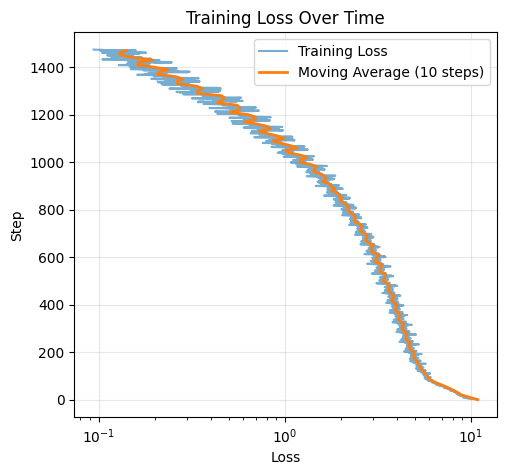

In [8]:
# Plot loss curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(all_losses, all_steps, alpha=0.6, label='Training Loss')
plt.plot(
    [np.mean(all_losses[max(0, i-10):i+1]) for i in range(0, len(all_losses), 10)],
    all_steps[::10],
    linewidth=2,
    label='Moving Average (10 steps)'
)

plt.xlabel('Loss')
plt.ylabel('Step')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')


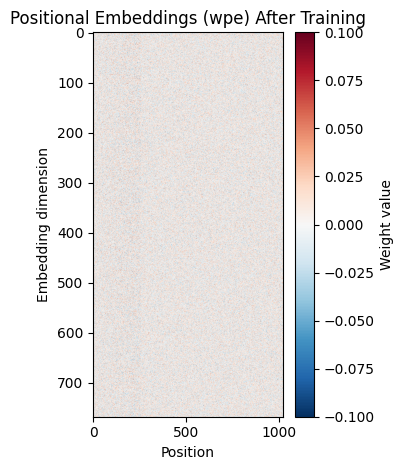


📊 Positional embedding statistics:
   Shape: (1024, 768)
   Mean: 0.000019
   Std: 0.019544
   Min: -0.094534
   Max: 0.088063


In [9]:
# Plot positional embeddings
plt.subplot(1, 2, 2)
wpe_weights = model.transformer.wpe.weight.detach().cpu().numpy()
plt.imshow(wpe_weights.T, aspect='auto', cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Weight value')
plt.xlabel('Position')
plt.ylabel('Embedding dimension')
plt.title('Positional Embeddings (wpe) After Training')

plt.tight_layout()
plt.savefig('training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Positional embedding statistics:")
print(f"   Shape: {wpe_weights.shape}")
print(f"   Mean: {wpe_weights.mean():.6f}")
print(f"   Std: {wpe_weights.std():.6f}")
print(f"   Min: {wpe_weights.min():.6f}")
print(f"   Max: {wpe_weights.max():.6f}")

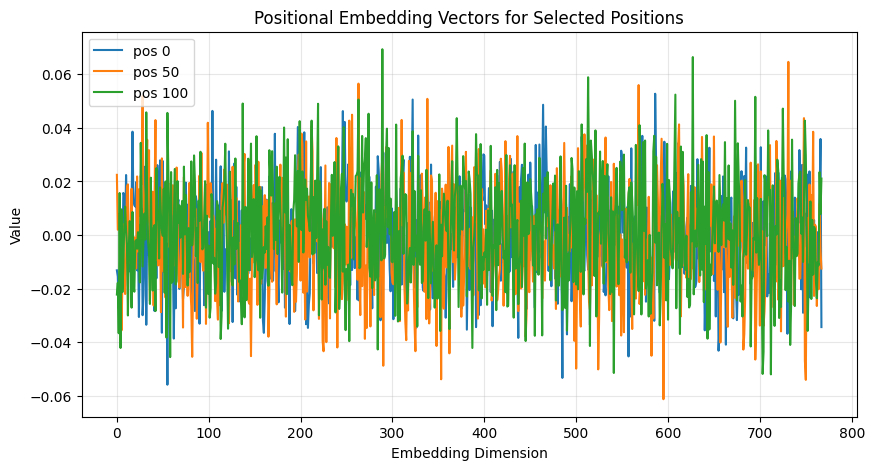

In [13]:
positions = [0, 50, 100]

plt.figure(figsize=(10, 5))
for pos in positions:
    plt.plot(wpe_weights[pos], label=f"pos {pos}")

plt.title("Positional Embedding Vectors for Selected Positions")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

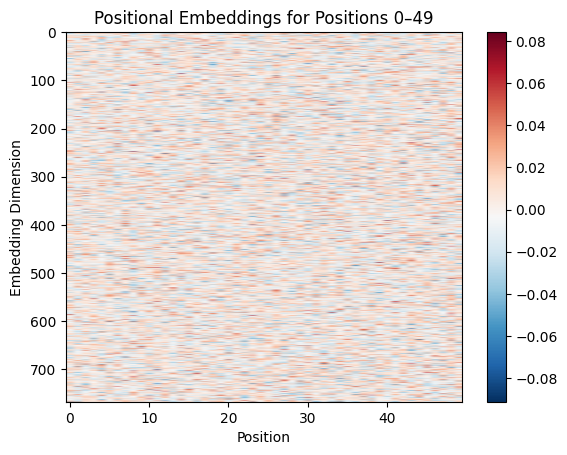

In [14]:
start = 0
end = 50  # positions 0–49

plt.imshow(wpe_weights[start:end].T, aspect='auto', cmap='RdBu_r')
plt.colorbar()
plt.xlabel("Position")
plt.ylabel("Embedding Dimension")
plt.title(f"Positional Embeddings for Positions {start}–{end-1}")
plt.show()

## Upload the trained model to hugging face

In [ ]:
import torch
checkpoint = torch.load('/content/gpt2_checkpoint.pt', map_location='cpu', weights_only=False)

torch.save({
    'model_state_dict': checkpoint['model_state_dict'],
    'config': checkpoint['config'],
    'loss': checkpoint['loss'],
    'step': checkpoint['step'],
}, 'gpt2_model_only.pt')

from huggingface_hub import upload_file
upload_file(
    path_or_fileobj="/content/gpt2_model_only.pt",
    path_in_repo="gpt2_model.pt",
    repo_id="dkamat/gpt2-from-stratch",
    repo_type="space",
    commit_message="new trained model gpt2_model.pt"
)